# Project 1
Due March 12, 2019.

For the midterm project, you will develop a Tolman-Oppenheimer-Volkov (TOV) solver to compute the hydrostatic structure of a relativistic neutron star. You will use this to determine the maximum masses of cold neutron stars (NSs) for several different equations of state (EOS).

Your code should adhere to the course Coding Standards.

  - Write a numerical solver for the spherically-symmetric TOV equations using a fourth-order Runge-Kutta integrator. Assume a polytropic EOS specified by $K$ and $\gamma$. You may find these notes particularly helpful.
  
\begin{align}
\frac{dm}{dr} &= 4\pi r^2 \rho \\
\frac{dP}{dr} &= -\frac{\rho m }{r^2}\left ( 1 + \frac{P}{\rho}\right ) \left( 1 + \frac{4\pi P^3}{m} \right ) \left ( 1 - \frac{2m}{r}\right ) ^{-1}\\
\frac{d\Phi}{dr} &= - \frac{1}{\rho} \frac{dP}{dr}\left( 1 + \frac{P}{\rho}\right ) ^{-1}
\end{align}

For a polytropic eos: $P = K \rho_0^\Gamma$, where $K$ is the polytropic gas constant and $n$ defined by $\Gamma \equiv 1 + 1/n$ is the polytropic index. We then have   $\rho = \rho_0 + P/(\Gamma -1 )$  and $\rho_0 \epsilon = P/(\Gamma -1 )$, which gives
   
\begin{equation}
\epsilon= \frac{P}{(\gamma - 1)\rho_0}
\end{equation}
   
Below, constants are the equivalent barred ones.

In [320]:
import numpy as np
import matplotlib.pyplot as plt

def deriv_P(r, rho, m, P):
    return - rho * m / r**2 * (1 +  P /rho) * ( 1 + 4*np.pi*P*r**3/m)/(1-2*m/r)

def deriv_m(r, rho):
    return 4*np.pi*r**2 * rho

def deriv_Phi(r, rho, P, dPdr):
    return - 1/rho * dPdr / ( 1 + P/rho )

In [321]:
from scipy.integrate import ode

def f(r, y):
    (m, P, Phi) = y
    rho0 = P ** (1/gamma)
    
    eps = P / ((gamma - 1 ) * rho0 )
    rho = rho0 + P/(gamma - 1)
    dmdr = 4 * np.pi * r**2 * rho
    if r == 0 or m == 0:
        dPdr = 0
    else:
        dPdr = - rho * m / r**2 * ((1 +  P /rho) \
                                 * ( 1 + 4*np.pi*P*r**3/m)/(1-2*m/r))
    dPhidr = - 1/rho * dPdr / ( 1 + P/rho )
    if verbose:
        print(0, r, m, rho, eps)
        print(1, dmdr)
        print(2, dPdr)
        print(3, dPhidr)
    return [dmdr, dPdr, dPhidr]

In [444]:
def solve_star(rhoc = 0.420, verbose = False):
    Pc = rhoc ** gamma

    rho0 = rhoc - Pc/(gamma - 1)

    solver = ode(f).set_integrator('dopri5')

    y0 = [0, Pc, 0]
    solver.set_initial_value(y0, 0)

    rmax_km = 20 # km 
    rmax = rmax_km * 1e5 * 6.7706e-6
    Nr = 2000
    dr =  rmax / Nr

    values = []
    r_values = []
    i = 0
    m = 0
    P = Pc
    M0 = 0
    while solver.successful() and solver.t < rmax and P > 0:
        solver.integrate(solver.t+dr)

        values.append(solver.y)
        r_values.append(solver.t)
        m = solver.y[0]
        P = solver.y[1]
        i+=1

        # just got this here temporarily
        if m < 0:
            raise ValueError('negative mass!')

    if verbose:
        print(i)
    values = np.array(values)
    return solver, values, r_values

0.396702816957468 0.8888888888888888
24.298499999999997 0.5523559262441818


/home/halvard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


Text(0.5,0,'r [km]')

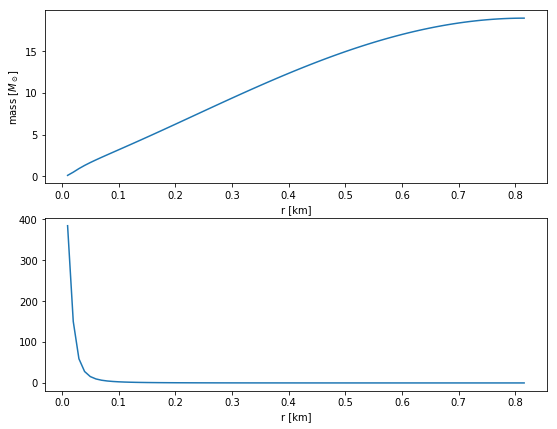

In [445]:
n = 1# 4/7
gamma = 1+1/n
verbose = False


K = 30000 # 1.98183e-6 # corresponds to K = 30000 in cgs

rho_cgs = 5e14 # g / cm^3

density_factor = 1.6199e-18   # cgs to geometrized units
rho_geom = rho_cgs * density_factor # geometrized units G = c = M_sun
rhoc_bar = rho_geom * K**n

solver, values, r_values = solve_star(rhoc_bar)

rho_bar = rho_geom * K ** n
R = r_values[-1]
M = values.T[0][-1]
print(2*M/R, 8/9)
print(rho_bar, R)


mass = values.T[0] * K**(n/2)

length_factor = 6.7706e-6
r_km = np.array(r_values)/ (1e5 * length_factor)
fig,[ax1,ax2] = plt.subplots(2,1, figsize = [9,7])

ax1.plot(r_km, mass)
ax1.set_xlabel('r [km]')
ax1.set_ylabel('mass [$M_\odot$]')
ax2.plot(r_km, values.T[1])
ax2.set_xlabel('r [km]')


/home/halvard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


rho_max:  0.3076923076923077
M max  :  0.16369512351625135


Text(0,0.5,'$\\bar {M}$')

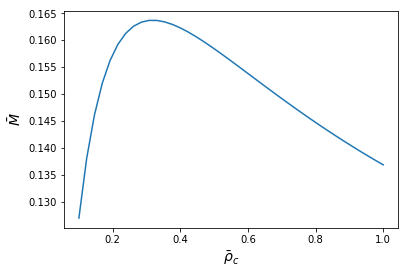

In [451]:
# rho_cgs = 5e14 # g / cm^3
# density_factor = 1.6199e-18   # cgs to geometrized units

# rho_geom = rho_cgs * density_factor # geometrized units G = c = M_sun
# rho_bar = rho_geom * K ** n
rb = []
Mb = []

rho_bar_vals = np.linspace(0.1,1,40)
for rho_bar in rho_bar_vals:
    
    rho_geom = rho_bar * K ** (-n)
    solver, values, r_values = solve_star(rho_bar)

    M_bar = values.T[0][-1]

    rb.append(rho_bar)
    Mb.append(M_bar)
    # print(rho_bar, M_bar)
print('rho_max: ',rb[np.argmax(Mb)])
print('M max  : ', np.max(Mb))
plt.plot(rb,Mb)
plt.xlabel(r'$\bar \rho_c$', size = 14)
plt.ylabel(r'$\bar {M}$', size = 14)

    
  - Determine the maximum mass of a cold NS for $K=30000$ (in $G=c=M_\odot=1$ units) and $\gamma=2.75$.
 

In [ ]:
for

 
  - Now, modify your code to use any arbitrary table-based EOS. Specifically, make your solver compatible with the EOS available on stellarcollapse.org. There is example code on that site in C++ and Fortran for reading and using the tables there, and working with the EOS tables is trivial in Python using h5py.
 

 
  - Determine the maximum mass for any five of the EOS available on stellarcollapse.org.
 

 
  - Make mass vs. radius plots for these same five EOS.